In [37]:
import pandas as pd
import pygmt
import os
import math
import numpy as np

A point is defined as a set of latitude, longitude, and depth, which
is located in the corner between the tail of the vector pointing in
the strike direction and the dip direction (nearest to the surface).
The shape is defined by length, width, dx, and dy. The length is the
measurement of the quadrilateral in the direction of strike, and
width is the measurement of quadrilateral in the direction of dip.
Dx is the measurement on the plane in the strike direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
Dy is the measurement on the plane in the dip direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
The orientation is defined by azimuth and angle from
horizontal, strike and dip respectively. For example in plane view:
```
                    strike direction
                p1*------------------->>p2
                *        | dy           |
         dip    |--------o              |
      direction |   dx    known point   | Width
                |                       |
                V                       |
                p4----------------------p3
                        Length
```

In the example below, each row represents a single rupture plane defined by 5 points, each with lat/lon/depth, (p1, p2, p3, p4, p1)

In [38]:
file_path = '/Users/hyin/shakemap_profiles/default/data/us6000jllz/ffsimmer_v02_ffsimmer-evolution/rupt_quads.txt'
hypocenter = [37.0143, 37.2256]

In [39]:
def parse_rupture_file(file_path):
    ruptures = []  # List to store all ruptures
    current_rupture = []  # Temporary list to store points for the current rupture

    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith("#Origin"):
                # Start of a new rupture, reset the current rupture
                current_rupture = []
            elif line == ">":
                # End of the current rupture, process and store it
                if len(current_rupture) == 5:  # Ensure there are 5 points
                    rupture = {
                        "p1": current_rupture[0],
                        "p2": current_rupture[1],
                        "p3": current_rupture[2],
                        "p4": current_rupture[3],
                    }
                    ruptures.append(rupture)
                current_rupture = []  # Reset for the next rupture
            elif line:
                # Parse a point (lat, lon, depth)
                point = tuple(map(float, line.split()))
                current_rupture.append(point)
    data = []
    for idx, rupture in enumerate(ruptures):
        data.append({
            "rupture_id": idx + 1,
            "p1_lat": rupture["p1"][0], "p1_lon": rupture["p1"][1], "p1_depth": rupture["p1"][2],
            "p2_lat": rupture["p2"][0], "p2_lon": rupture["p2"][1], "p2_depth": rupture["p2"][2],
            "p3_lat": rupture["p3"][0], "p3_lon": rupture["p3"][1], "p3_depth": rupture["p3"][2],
            "p4_lat": rupture["p4"][0], "p4_lon": rupture["p4"][1], "p4_depth": rupture["p4"][2],
        })
    
    return pd.DataFrame(data)

ruptures = parse_rupture_file(file_path)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    Args:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    Returns:
        Distance in kilometers.
    """
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

ruptures["fault_length_km"] = ruptures.apply(lambda row: haversine(row["p1_lat"], row["p1_lon"], row["p2_lat"], row["p2_lon"]), axis=1)
ruptures["fault_width_km"] = np.sqrt((ruptures.apply(lambda row: haversine(row["p1_lat"], row["p1_lon"], row["p4_lat"], row["p4_lon"]), axis=1)**2)+ (ruptures["p4_depth"]**2))
ruptures["aspect_ratio"] = ruptures["fault_length_km"] / ruptures["fault_width_km"]
ruptures


,rupture_id,p1_lat,p1_lon,p1_depth,p2_lat,p2_lon,p2_depth,p3_lat,p3_lon,p3_depth,p4_lat,p4_lon,p4_depth,fault_length_km,fault_width_km,aspect_ratio
0,1,36.7411,36.5130,-0.0000,37.4407,37.2679,-0.0000,37.4012,37.3256,49.9993,36.7020,36.5705,50.0000,102.639171,50.449649,2.034487
1,2,37.4576,37.0861,1.2114,37.0143,37.0294,1.2114,37.0209,36.9473,29.4270,37.4643,37.0035,29.4270,49.547621,30.325815,1.633843
2,3,36.7728,37.5792,1.5957,37.2460,36.8994,1.5957,37.2900,36.9475,48.2496,36.8165,37.6274,48.2491,80.075285,48.682728,1.644840
3,4,37.5753,36.8316,1.2330,36.9269,37.2449,1.2330,36.8834,37.1377,47.5738,37.5314,36.7237,47.5739,80.847883,48.760423,1.658064
4,5,36.6892,37.3737,1.0289,37.2966,36.9129,1.0289,37.3229,36.9676,47.1361,36.7154,37.4281,47.1358,78.970997,47.474115,1.663454
5,6,37.1977,37.0102,1.6068,36.8342,37.8138,1.6068,36.7967,37.7872,49.6017,37.1600,36.9839,49.6018,82.001211,49.833131,1.645516
6,7,37.8816,36.4699,-0.0000,37.1190,37.1580,0.0000,37.0739,37.0790,49.9998,37.8361,36.3906,50.0000,104.283811,50.735239,2.055451
7,8,36.4445,35.3886,0.0000,37.2487,37.2779,0.0000,37.2462,37.2796,49.9999,36.4420,35.3903,50.0000,190.413202,50.001004,3.808188
8,9,37.3623,37.0396,0.1692,36.6539,37.0961,0.1692,36.6480,36.9825,45.4760,37.3564,36.9249,45.4760,78.930083,46.596845,1.693893
9,10,37.0397,36.2267,2.0350,37.1976,37.0293,2.0350,37.1163,37.0545,44.1311,36.9586,36.2527,44.1316,73.296590,45.102683,1.625105


# Calculate fault length, width, etc. 

## Create PyGMT fig of fault traces

ERROR 1: Features without geometry not supported by GMT writer.
ERROR 1: Features without geometry not supported by GMT writer.


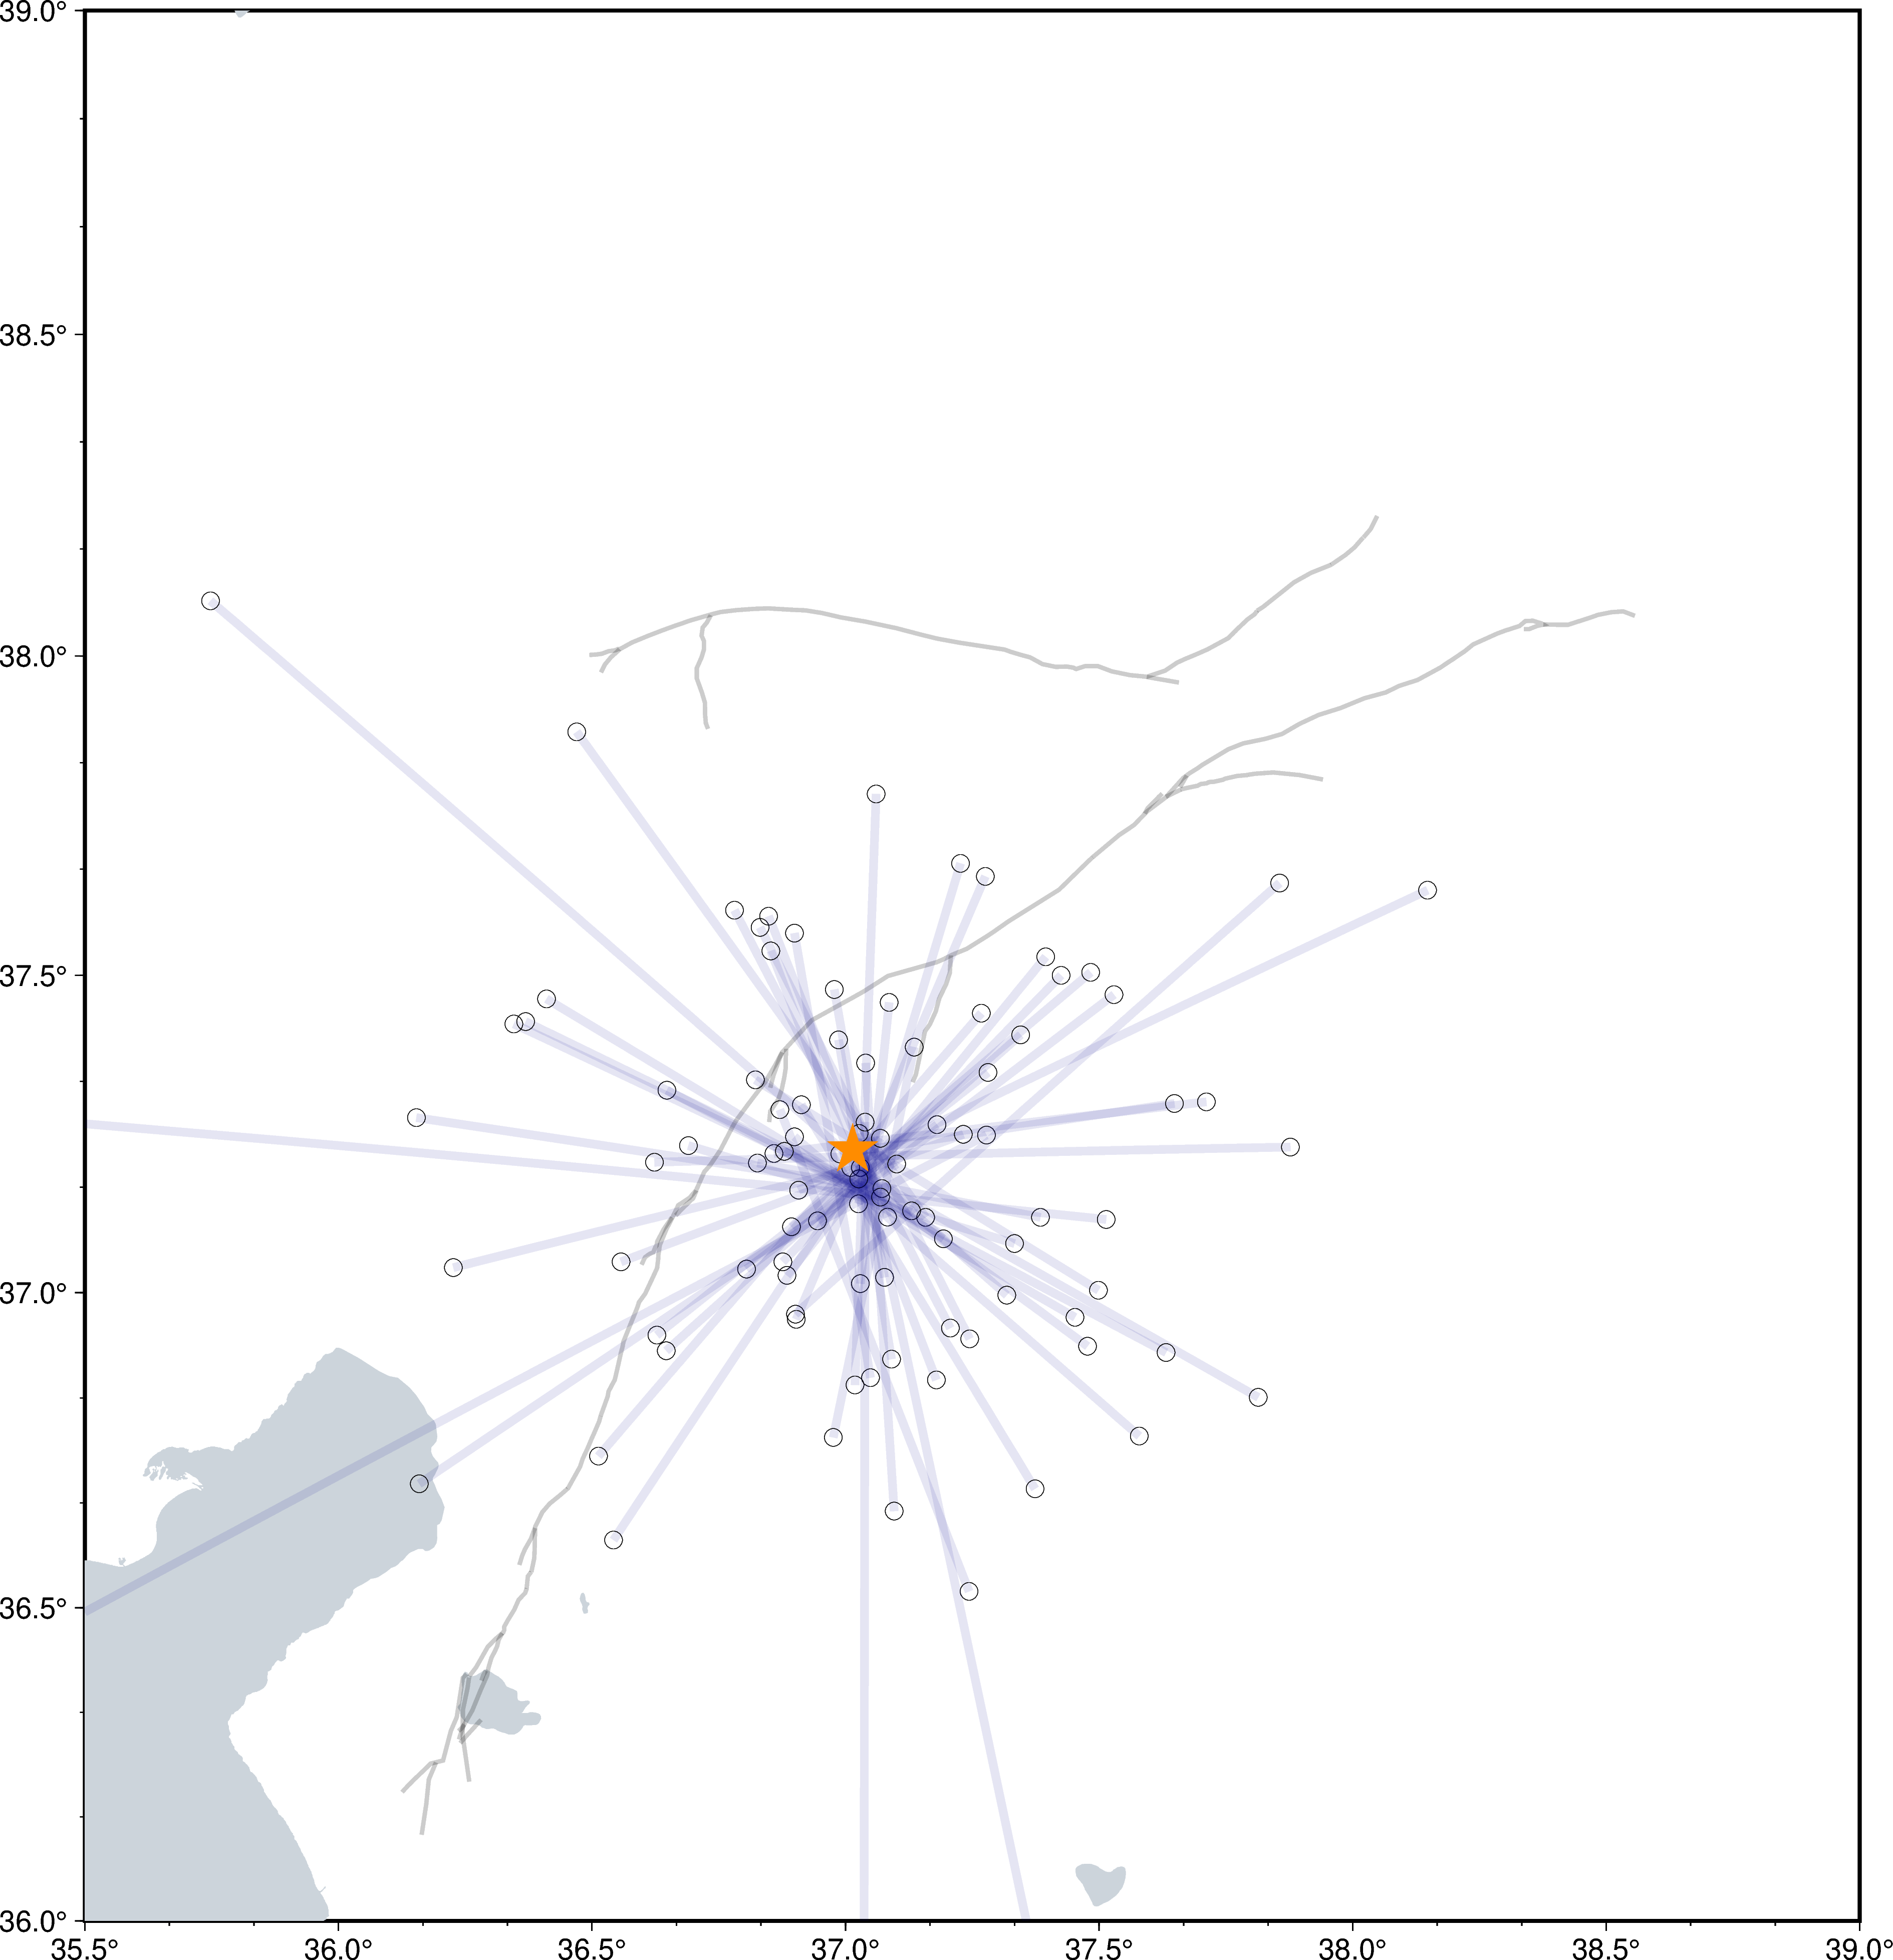

In [40]:
directory = os.path.dirname(file_path)

# Initialize figure
fig = pygmt.Figure()
# Set PyGMT universal configurations
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT="14p")
projection = 'M0/0/30c'
rgn = [35.5, 39, 36, 39]

fig.basemap(region=rgn, projection=projection, frame=True)
fig.coast(shorelines=False, region=rgn, projection=projection, water='204/212/219')
## Plot Fault ruptures (iterate over each fault)
for index, row in ruptures.iterrows():
  p1 = [row['p1_lon'],row['p1_lat']]
  p2 = [row['p2_lon'],row['p2_lat']]
  # p3 = row['lons'][2]
  # p4 = row['lons'][3]
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], pen='4p,darkblue',  transparency=90, label=f"Fault Realizations +S.5c", region=rgn, projection=projection)
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], style="c0.3c", pen="black")



# Plot hypocenter
fig.plot(x=hypocenter[0], y = hypocenter[1], style="a0.9c", fill="darkorange", label="M7.8 Hypocenter")

# USGS Fault rupture
file = '/Users/hyin/usgs_mendenhall/2023_turkey_pathways/map-layers/map_layers/Turkey_Emergency_EQ_Data/simple_fault_2023-03-15/simple_fault_2023-3-15.shp'
fig.plot(data=file, pen='2p,black', transparency=80, label=f"Surface rupture (USGS)+S.5c", region=rgn, projection=projection)



fig.show()
fig.savefig(directory+'/products/ruptures_map-view.png')


In [41]:
hypocenter = [37.0143, 37.2256]



Fitted parameters: a = 0.0001220703125000004, b = 1.3862943611198901


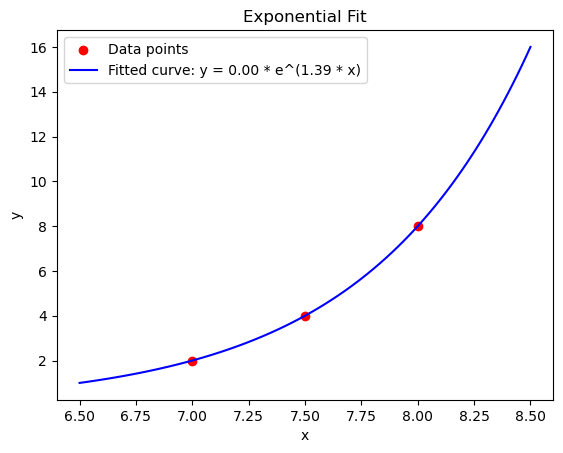

In [42]:
import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential function
def exponential(x, a, b):
    return a * np.exp(b * x)

# Data points
x_data = np.array([7, 7.5, 8])
y_data = np.array([2, 4, 8])

# Fit the exponential function to the data
params, covariance = curve_fit(exponential, x_data, y_data)

# Extract the fitted parameters
a, b = params
print(f"Fitted parameters: a = {a}, b = {b}")

# Generate points for the fitted curve
x_fit = np.linspace(6.5, 8.5, 100)
y_fit = exponential(x_fit, a, b)

# Plot the data and the fitted curve
plt.scatter(x_data, y_data, color='red', label='Data points')
plt.plot(x_fit, y_fit, color='blue', label=f'Fitted curve: y = {a:.2f} * e^({b:.2f} * x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Fit')
plt.show()

## Convert to UTM (maybe don't need this??)

In [43]:
from pyproj import Proj, transform

# Define a function to convert lat/lon to UTM
def latlon_to_utm(lat, lon, zone_number):
    """
    Convert latitude and longitude to UTM coordinates.
    Args:
        lat (float): Latitude in decimal degrees.
        lon (float): Longitude in decimal degrees.
        zone_number (int): UTM zone number.
    Returns:
        tuple: UTM easting and northing.
    """
    proj_utm = Proj(proj="utm", zone=zone_number, ellps="WGS84")
    easting, northing = proj_utm(lon, lat)
    return easting, northing

# Determine the UTM zone for your data (you can calculate it dynamically if needed)
utm_zone = 37  # Example: UTM zone 37 for longitude ~37

# Apply the conversion to the DataFrame
ruptures["p1_utm"] = ruptures.apply(lambda row: latlon_to_utm(row["p1_lat"], row["p1_lon"], utm_zone), axis=1)
ruptures["p2_utm"] = ruptures.apply(lambda row: latlon_to_utm(row["p2_lat"], row["p2_lon"], utm_zone), axis=1)
ruptures["p3_utm"] = ruptures.apply(lambda row: latlon_to_utm(row["p3_lat"], row["p3_lon"], utm_zone), axis=1)
ruptures["p4_utm"] = ruptures.apply(lambda row: latlon_to_utm(row["p4_lat"], row["p4_lon"], utm_zone), axis=1)

# Split the UTM tuples into separate columns for easting and northing
ruptures[["p1_easting", "p1_northing"]] = pd.DataFrame(ruptures["p1_utm"].tolist(), index=ruptures.index)
ruptures[["p2_easting", "p2_northing"]] = pd.DataFrame(ruptures["p2_utm"].tolist(), index=ruptures.index)
ruptures[["p3_easting", "p3_northing"]] = pd.DataFrame(ruptures["p3_utm"].tolist(), index=ruptures.index)
ruptures[["p4_easting", "p4_northing"]] = pd.DataFrame(ruptures["p4_utm"].tolist(), index=ruptures.index)

# Drop the intermediate UTM tuple columns if no longer needed
ruptures.drop(columns=["p1_utm", "p2_utm", "p3_utm", "p4_utm"], inplace=True)

ruptures

,rupture_id,p1_lat,p1_lon,p1_depth,p2_lat,p2_lon,p2_depth,p3_lat,p3_lon,p3_depth,...,fault_width_km,aspect_ratio,p1_easting,p1_northing,p2_easting,p2_northing,p3_easting,p3_northing,p4_easting,p4_northing
0,1,36.7411,36.5130,-0.0000,37.4407,37.2679,-0.0000,37.4012,37.3256,49.9993,...,50.449649,2.034487,277948.529059,4.069036e+06,346772.413926,4.145171e+06,351799.294495,4.140696e+06,282973.240245,4.064566e+06
1,2,37.4576,37.0861,1.2114,37.0143,37.0294,1.2114,37.0209,36.9473,29.4270,...,30.325815,1.633843,330726.356135,4.147357e+06,324687.002349,4.098274e+06,317397.987340,4.099161e+06,323435.854622,4.148252e+06
2,3,36.7728,37.5792,1.5957,37.2460,36.8994,1.5957,37.2900,36.9475,48.2496,...,48.682728,1.644840,373203.951037,4.070610e+06,313689.450212,4.124230e+06,318062.078615,4.129019e+06,377575.265129,4.075395e+06
3,4,37.5753,36.8316,1.2330,36.9269,37.2449,1.2330,36.8834,37.1377,47.5738,...,48.760423,1.658064,308515.768613,4.160906e+06,343681.876061,4.088202e+06,334038.951240,4.083557e+06,298868.187822,4.156260e+06
4,5,36.6892,37.3737,1.0289,37.2966,36.9129,1.0289,37.3229,36.9676,47.1361,...,47.474115,1.663454,354705.769534,4.061627e+06,315010.871054,4.129818e+06,319922.501324,4.132631e+06,359613.914137,4.064453e+06
5,6,37.1977,37.0102,1.6068,36.8342,37.8138,1.6068,36.7967,37.7872,49.6017,...,49.833131,1.645516,323405.209981,4.118659e+06,394225.724455,4.077136e+06,391800.908198,4.073006e+06,320981.839872,4.114525e+06
6,7,37.8816,36.4699,-0.0000,37.1190,37.1580,0.0000,37.0739,37.0790,49.9998,...,50.735239,2.055451,277489.355008,4.195696e+06,336354.118415,4.109661e+06,329233.709904,4.104797e+06,270372.873414,4.190839e+06
7,8,36.4445,35.3886,0.0000,37.2487,37.2779,0.0000,37.2462,37.2796,49.9999,...,50.001004,3.808188,176285.883121,4.039317e+06,347268.596049,4.123852e+06,347414.337084,4.123571e+06,176427.927292,4.039034e+06
8,9,37.3623,37.0396,0.1692,36.6539,37.0961,0.1692,36.6480,36.9825,45.4760,...,46.596845,1.693893,326393.389510,4.136867e+06,329824.691788,4.058168e+06,319655.895234,4.057721e+06,316220.390710,4.136430e+06
9,10,37.0397,36.2267,2.0350,37.1976,37.0293,2.0350,37.1163,37.0545,44.1311,...,45.102683,1.625105,253344.364644,4.102874e+06,325100.286885,4.118612e+06,327151.948481,4.109545e+06,255397.388189,4.093807e+06


## Pull CMT data

## gCMT
```
202302060117A TURKEY
  Date: 2023/ 2/ 6   Centroid Time:  1:18:10.8 GMT
  Lat=  37.55  Lon=  37.45
  Depth= 15.1   Half duration=18.6
  Centroid time minus hypocenter time: 36.5
  Moment Tensor: Expo=27  -0.371 -5.110 5.480 -1.410 1.350 1.300 
  Mw = 7.8    mb = 0.0    Ms = 7.8   Scalar Moment = 5.8e+27
  Fault plane:  strike=51    dip=70   slip=-4
  Fault plane:  strike=143    dip=86   slip=-160
```

In [44]:
dir = '/Users/hyin/usgs_mendenhall/nodal-plane-selection/2023_turkey/'
with open(dir + 'cmt_dict.json') as file:
    content = file.read()   # read the file into a string
    cmt_dict = json.loads(content)  # convert the string to a dictionary

cmt_lat =       cmt_dict['latitude']
cmt_lon =       cmt_dict['longitude']
cmt_depth =     cmt_dict['depth']
cmt_strike =    cmt_dict["nodal-plane-1-strike"]
cmt_dip =       cmt_dict["nodal-plane-1-dip"]
cmt_rake =      cmt_dict["nodal-plane-1-rake"]
cmt_dc =        cmt_dict["percent-double-couple"]
cmt_mag =       cmt_dict["derived-magnitude"]
focal_mechanism = {"strike": float(cmt_strike), "dip": float(cmt_dip), "rake": float(cmt_rake), "magnitude": float(cmt_mag)}
cmt_dict

NameError: name 'json' is not defined

Plot CMT

In [ ]:
## USGS CMT
# Pass the focal mechanism data through the spec parameter. In addition provide
# scale, event location, and event depth
fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=float(cmt_dict['derived-longitude']),
    latitude=float(cmt_dict['derived-latitude']),
    depth=float(cmt_depth),
    pen="0.5p,gray30,solid",
)

## GCMT Solution
# https://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2023&mo=2&day=5&oyr=2023&omo=3&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=4&lmw=0&umw=10&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=0
# strike1, dip1, rake1,
# strike2, dip2, rake2,
# mantissa, exponent

#  Date: 2023/ 2/ 6   Centroid Time:  1:18:10.8 GMT
#   Lat=  37.55  Lon=  37.45
#   Depth= 15.1   Half duration=18.6
#   Centroid time minus hypocenter time: 36.5
#   Moment Tensor: Expo=27  -0.371 -5.110 5.480 -1.410 1.350 1.300 
#   Mw = 7.8    mb = 0.0    Ms = 7.8   Scalar Moment = 5.8e+27
#   Fault plane:  strike=51    dip=70   slip=-4
#   Fault plane:  strike=143    dip=86   slip=-160

focal_mechanism = {"strike1": -51, "dip1": 70, "rake1": -4, "strike2": -143, "dip2": 86, "rake2":-160, "mantissa":5.8, "exponent": 27}

fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=37.45,
    latitude=37.55,
    depth=15.1,
    pen="0.5p,gray30,solid",
)

## Plot aftershocks

## FROM CHanel

from libcomcat.search import search
from libcomcat.dataframes import get_detail_data_frame
from libcomcat.dataframes import get_summary_data_frame
import pandas as pd

if len(events) > 0:
    print("Returned %s events" % len(events))
    print("Downloading event details.")
    rows = []
    for event in events:
        row = {"id:": event.id}
        summary = event.toDict()
        if not event.hasProduct("moment-tensor"):
            rows.append(summary)
            continue
        row.update(summary)
        detail = event.getDetailEvent()
        tensor = detail.getProducts("moment-tensor", source="preferred")[0]
        row.update(tensor._product["properties"])
        # for key in tensor.properties:
        #     row[key] = tensor[key]
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(args.outfile, index=False)
else:
    print('0 events were returned for your search')